In [1]:
%matplotlib nbagg
import os
import glob
from collections import defaultdict, namedtuple
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import lsst.geom
import desc.sims_ci_pipe as scp

No module named 'lsst.sims'


In [2]:
def make_SourceCatalog(df):
    schema = afw_table.SourceTable.makeMinimalSchema()
    schema.addField('flux', type=float, doc='flux in nJy')
    src_cat = afw_table.SourceCatalog(schema)
    for iloc in range(len(df)):
        row = df.iloc[iloc]
        new_rec = src_cat.addNew()
        new_rec.set('id', int(row['id']))
        new_rec.set('coord_ra', lsst.geom.Angle(row.ra, lsst.geom.degrees))
        new_rec.set('coord_dec', lsst.geom.Angle(row.dec, lsst.geom.degrees))
        new_rec.set('flux', row['flux'])
    return src_cat

In [3]:
def match_meas_fluxes(butler, visit, truth_df0,
                      flux_type='base_PsfFlux', max_offset=0.1,
                      point_sources=True):
    flux_col = f'{flux_type}_instFlux'
    radius = lsst.geom.Angle(max_offset, lsst.geom.arcseconds)
    dfs = []
    datarefs = butler.subset('src', visit=visit)
    for i, dataref in enumerate(list(datarefs)):
        try:
            calib = dataref.get('calexp').getPhotoCalib()
        except:
            continue
        src = dataref.get('src')
        if point_sources:
            src = scp.get_point_sources(src)
        ras = np.degrees(src.get('coord_ra'))
        decs = np.degrees(src.get('coord_dec'))
        ra_min, ra_max = min(ras), max(ras)
        dec_min, dec_max = min(decs), max(decs)
        query = f'{ra_min} <= ra <= {ra_max} and {dec_min} <= dec <= {dec_max}'
        truth_df = truth_df0.query(query)
        truth_cat = make_SourceCatalog(truth_df)

        matches = afw_table.matchRaDec(truth_cat, src, radius)
        num_matches = len(matches)
        print(i, len(truth_df), len(src), num_matches)
        ids = np.zeros(num_matches, dtype=np.int)
        offsets = np.zeros(num_matches, dtype=np.float)
        true_fluxes = np.zeros(num_matches, dtype=np.float)
        meas_fluxes = np.zeros(num_matches, dtype=np.float)
        meas_fluxerrs = np.zeros(num_matches, dtype=np.float)

        for i, match in enumerate(matches):
            ids[i] = match.first['id']
            offsets[i] = np.degrees(match.distance)*3600*1000.
            true_fluxes[i] = match.first['flux']
            meas_fluxes[i] = calib.instFluxToNanojansky(match.second[flux_col])
            meas_fluxerrs[i] \
                = calib.instFluxToNanojansky(match.second[flux_col + 'Err'])

        dfs.append(pd.DataFrame(data=dict(id=ids, offset=offsets,
                                          true_flux=true_fluxes,
                                          meas_flux=meas_fluxes,
                                          meas_fluxerr=meas_fluxerrs)))
    df = pd.concat(dfs)
    return df

In [4]:
def zeros():
    return dict(ra=0, dec=0, flux=0, npts=0)

def make_lens_sys_truth_cat(df, id_col='lens_sys_id'):
    data = defaultdict(zeros)
    for iloc in range(len(df)):
        row = df.iloc[iloc]
        record = data[row[id_col]]
        record['ra'] += row.ra
        record['dec'] += row.dec
        record['flux'] += row.flux
        record['npts'] += 1
    df_data = defaultdict(list)
    for obj_id in data:
        df_data['id'].append(obj_id)
        df_data['ra'].append(data[obj_id]['ra']/data[obj_id]['npts'])
        df_data['dec'].append(data[obj_id]['dec']/data[obj_id]['npts'])
        df_data['flux'].append(data[obj_id]['flux'])
    return pd.DataFrame(data=df_data)

In [5]:
df_stars = pd.read_pickle('src_truth_match_v709692-i.pkl')

In [13]:
visit = 709692
band = 'i'

In [7]:
butler = dp.Butler('repo_agns')
truth_df0 = pd.read_pickle(f'agn_fluxes_v{visit}.pkl')
df_agns = match_meas_fluxes(butler, visit, truth_df0)
print(len(df_agns))
print()

0 0 208 0
1 265 242 9
2 133 239 3
3 378 223 13
4 652 246 9
5 582 193 7
6 660 220 10
7 536 191 12
63



In [8]:
butler = dp.Butler('repo_lensed_agns')
truth_df0 = make_lens_sys_truth_cat(pd.read_pickle(f'lensed_agn_fluxes_v{visit}.pkl'))
df_lensed_agns = match_meas_fluxes(butler, visit, truth_df0)
print(len(df_lensed_agns))
print()

0 0 204 0
1 37 250 20
2 12 235 2
3 54 233 26
4 88 284 48
5 77 215 32
6 108 271 60
7 68 230 44
232



In [9]:
butler = dp.Butler('repo_lensed_sne')
truth_df0 = make_lens_sys_truth_cat(pd.read_pickle(f'lensed_sne_fluxes_v{visit}.pkl'))
df_lensed_sne = match_meas_fluxes(butler, visit, truth_df0)
print(len(df_lensed_sne))
print()

0 22 207 0
1 0 204 0
2 29 233 0
3 8 233 0
4 79 214 0
5 91 236 0
6 81 184 0
7 84 202 0
8 82 182 0
9 23 191 0
10 64 200 0
11 2 219 0
12 70 191 0
13 37 238 0
14 47 289 0
15 3 250 0
16 91 166 0
17 85 223 0
18 69 193 0
19 69 251 0
20 98 222 0
21 71 213 0
22 20 194 0
23 75 200 0
24 98 243 1
25 78 222 0
26 80 213 0
27 19 178 0
28 76 182 0
29 62 190 0
30 14 176 0
31 57 237 0
32 12 197 0
33 60 243 0
34 58 213 0
35 0 201 0
1



In [10]:
butler = dp.Butler('repo_hosts')
truth_df0 = make_lens_sys_truth_cat(pd.read_pickle(f'host_fluxes_v{visit}.pkl'), id_col='id')
df_hosts = match_meas_fluxes(butler, visit, truth_df0, flux_type='base_CircularApertureFlux_12_0',
                             point_sources=False)
print(len(df_hosts))
print()

0 0 648 0
1 66 1286 0
2 34 1238 0
3 148 483 6
4 197 1158 5
5 164 362 5
6 206 418 3
7 175 388 3
22



<IPython.core.display.Javascript object>


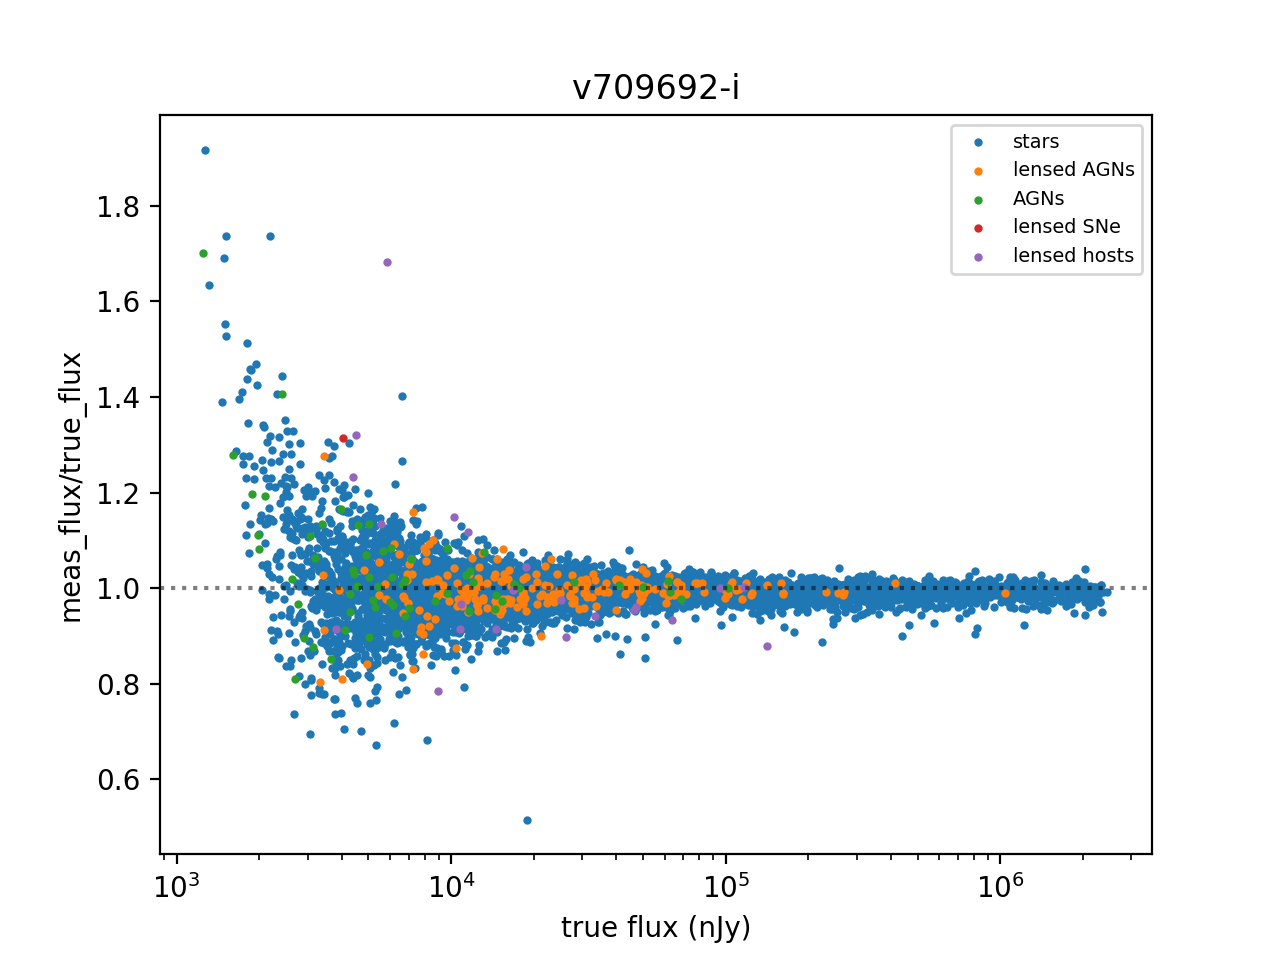

In [16]:
plt.figure()

plt.scatter(df_stars['true_flux'], df_stars['meas_flux']/df_stars['true_flux'], s=4, label='stars')
plt.scatter(df_lensed_agns['true_flux'], df_lensed_agns['meas_flux']/df_lensed_agns['true_flux'], s=4,
            label='lensed AGNs', alpha=1)
plt.scatter(df_agns['true_flux'], df_agns['meas_flux']/df_agns['true_flux'], s=4,
            label='AGNs', alpha=1)
plt.scatter(df_lensed_sne['true_flux'], df_lensed_sne['meas_flux']/df_lensed_sne['true_flux'], s=4,
            label='lensed SNe', alpha=1)
plt.scatter(df_hosts['true_flux'], df_hosts['meas_flux']/df_hosts['true_flux'], s=4,
            label='lensed hosts', alpha=1)
plt.xscale('log')
plt.axhline(1, linestyle=':', color='black', alpha=0.5)
plt.legend(fontsize='x-small')
plt.title(f'v{visit}-{band}')
plt.xlabel('true flux (nJy)')
plt.ylabel('meas_flux/true_flux')
plt.savefig(f'Run3.0i_instcat_flux_checks_v{visit}-{band}.png')

In [12]:
datarefs = butler.subset('calexp', visit=visit)
calexp = list(datarefs)[0].get('calexp')
psf = calexp.getPsf()

psf.computeShape().getDeterminantRadius()*0.2*2.35

0.9386509834402811